In [1]:
import torch
import torch.nn as nn

In [2]:
class Block1(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x):
    x = self.conv1(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class ConvBlockEncoder(nn.Module): # need to add nn.Module here
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=2, padding=1) # before padding it was 64 x 63 x 63 x 63. by adding 1, you add one to each dimension needed
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x):
    x = self.conv1(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class ConvBlockDecoder(nn.Module):
  def __init__(self, input_channels, output_channels):
    super().__init__()
    self.transconv = nn.ConvTranspose3d(in_channels=input_channels, out_channels=input_channels, kernel_size=2, stride=2)
    self.conv1 = nn.Conv3d(in_channels=input_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
    self.instnorm = nn.InstanceNorm3d(output_channels)
    self.lrelu = nn.LeakyReLU()
    self.conv2 = nn.Conv3d(in_channels=output_channels, out_channels=output_channels, kernel_size=3, stride=1, padding=1)
  def forward(self, x, concat_tensor):
    x = self.transconv(x)
    # print("after transpose: " + str(x.shape))
    x = torch.add(x, concat_tensor)
    # print("after concat: " + str(x.shape))
    x = self.conv1(x)
    # print("after conv1: " + str(x.shape))
    x = self.instnorm(x)
    x = self.lrelu(x)
    x = self.conv2(x)
    x = self.instnorm(x)
    x = self.lrelu(x)
    return x

class nnUNet(nn.Module):
  def __init__(self, input_shape):
    super().__init__()
    self.convblock1 = Block1(4, 32)
    self.convblock2 = ConvBlockEncoder(32, 64)
    self.convblock3 = ConvBlockEncoder(64, 128)
    self.convblock4 = ConvBlockEncoder(128, 256)
    self.convblock5 = ConvBlockEncoder(256, 320)
    self.convblock6 = ConvBlockEncoder(320, 320)

    self.convblock7 = ConvBlockDecoder(320, 256)
    self.convblock8 = ConvBlockDecoder(256, 128)
    self.convblock9 = ConvBlockDecoder(128, 64)
    self.convblock9b = nn.Conv3d(in_channels=64, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC
    self.convblock10 = ConvBlockDecoder(64, 32)
    self.convblock10b = nn.Conv3d(in_channels=32, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC
    self.convblock11 = ConvBlockDecoder(32, 32)
    self.convblock11b = nn.Conv3d(in_channels=32, out_channels=3, kernel_size=1, stride=1) # output is 3 channels for WT, ET, TC

    self.softmax = nn.Softmax(dim=1)

  def forward(self, x, ):
    print(x.shape) # [4, 128, 128, 128]

    # ENCODER
    x1 = self.convblock1(x)
    print(x1.shape) # [32, 128, 128, 128]

    x2 = self.convblock2(x1)
    print(x2.shape) # [64, 64, 64, 64]

    x3 = self.convblock3(x2)
    print(x3.shape) # [128, 32, 32, 32]

    x4 = self.convblock4(x3)
    print(x4.shape) # [256, 16, 16, 16]

    x5 = self.convblock5(x4)
    print(x5.shape) # [320, 8, 8, 8]

    x6 = self.convblock6(x5)
    print(x6.shape) # [320, 4, 4, 4]

    x7 = self.convblock7(x6, x5)
    print(x7.shape) # [256, 8, 8, 8]

    x8 = self.convblock8(x7, x4)
    print(x8.shape) # [128, 16, 16, 16]

    x9 = self.convblock9(x8, x3)
    print(x9.shape) # [64, 32, 32, 32] - add one softmax here

    x9b = self.convblock9b(x9) 
    print(x9b.shape) # [3, 32, 32, 32]

    prob3 = self.softmax(x9b)
    print(prob3.shape) # [3, 32, 32, 32]

    x10 = self.convblock10(x9, x2)
    print(x10.shape) # [32, 64, 64, 64] - add one softmax here

    x10b = self.convblock10b(x10)
    print(x10b.shape) # [3, 64, 64, 64]

    prob2 = self.softmax(x10b)
    print(prob2.shape) # [3, 64, 64, 64]

    x11 = self.convblock11(x10, x1)
    print(x11.shape) # [32, 128, 128, 128]

    x11b = self.convblock11b(x11)
    print(x11b.shape) # [3, 128, 128, 128]

    prob1 = self.softmax(x11b)
    print(prob1.shape) # [3, 128, 128, 128] - i thought that the shape would change when using softmax, but only the values change to add up to 1

    return x11b, prob1, prob2, prob3

In [3]:
"""
when dim = 1
>>> torch.cat((x, x, x), 1)
tensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,
         -1.0969, -0.4614],
        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,
         -0.5790,  0.1497]])

softmax confusion:
- https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use
- https://discuss.pytorch.org/t/softmax-across-3d-tensor/83754
"""

'\nwhen dim = 1\n>>> torch.cat((x, x, x), 1)\ntensor([[ 0.6580, -1.0969, -0.4614,  0.6580, -1.0969, -0.4614,  0.6580,\n         -1.0969, -0.4614],\n        [-0.1034, -0.5790,  0.1497, -0.1034, -0.5790,  0.1497, -0.1034,\n         -0.5790,  0.1497]])\n\nsoftmax confusion:\n- https://stackoverflow.com/questions/49036993/pytorch-softmax-what-dimension-to-use\n- https://discuss.pytorch.org/t/softmax-across-3d-tensor/83754\n'

In [4]:
x = torch.rand(size=(1, 4, 128, 128, 128), dtype=torch.float32)
# print(x.shape)

model = nnUNet(x.shape)
print(model)
print()

out = model(x)
# print(out.shape)

nnUNet(
  (convblock1): Block1(
    (conv1): Conv3d(4, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(32, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (conv2): Conv3d(32, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (convblock2): ConvBlockEncoder(
    (conv1): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (conv2): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
  )
  (convblock3): ConvBlockEncoder(
    (conv1): Conv3d(64, 128, kernel_size=(3, 3, 3), stride=(2, 2, 2), padding=(1, 1, 1))
    (instnorm): InstanceNorm3d(128, eps=1e-05, momentum=0.1, affine=False, track_running_stats=False)
    (lrelu): LeakyReLU(negative_slope=0.01)
    (conv2): Con

In [5]:
output, probability1, probability2, probability3 = out

In [6]:
print(output.shape)
print(output)

torch.Size([1, 3, 128, 128, 128])
tensor([[[[[-1.0246e-01, -1.0046e-01, -2.4896e-01,  ..., -2.7401e-01,
            -3.5728e-01, -4.7974e-01],
           [-2.8341e-01, -6.1564e-01, -1.7873e-01,  ..., -6.8813e-01,
            -8.3832e-01, -9.2099e-01],
           [-1.5871e-02, -7.8973e-01, -1.2872e-01,  ..., -2.2662e-01,
            -2.9515e-01, -1.0737e+00],
           ...,
           [-3.0698e-01, -8.6763e-01, -7.4837e-01,  ..., -2.9426e-01,
            -8.0990e-01, -9.2565e-01],
           [-4.5426e-03, -7.3137e-01, -4.7272e-01,  ..., -4.3538e-01,
            -3.4943e-01, -8.3545e-01],
           [-2.2829e-01, -3.1331e-01, -1.7719e-01,  ..., -1.6982e-01,
            -4.8439e-01, -4.0153e-01]],

          [[-2.4938e-01, -6.5660e-02, -1.7203e-01,  ...,  7.9974e-02,
            -2.4000e-01, -2.6560e-01],
           [-2.9083e-01, -6.3065e-01, -8.7951e-01,  ..., -9.5857e-01,
            -6.9767e-01, -5.8267e-01],
           [-3.9403e-01, -4.7206e-02, -3.5414e-01,  ..., -7.2574e-01,
      

In [7]:
print(probability1.shape)
print(probability2.shape)
print(probability3.shape)

torch.Size([1, 3, 128, 128, 128])
torch.Size([1, 3, 64, 64, 64])
torch.Size([1, 3, 32, 32, 32])


In [9]:
probability1

tensor([[[[[0.2969, 0.2682, 0.2203,  ..., 0.2157, 0.2244, 0.2673],
           [0.2681, 0.2122, 0.2939,  ..., 0.1911, 0.1754, 0.1743],
           [0.3388, 0.1823, 0.3397,  ..., 0.3219, 0.2635, 0.1396],
           ...,
           [0.2940, 0.1398, 0.2092,  ..., 0.2836, 0.1869, 0.1948],
           [0.3162, 0.2554, 0.2576,  ..., 0.2640, 0.3057, 0.2121],
           [0.3183, 0.3252, 0.2911,  ..., 0.3010, 0.3004, 0.2549]],

          [[0.2377, 0.2527, 0.2547,  ..., 0.3182, 0.2418, 0.2137],
           [0.1622, 0.0937, 0.1418,  ..., 0.1185, 0.1855, 0.1694],
           [0.1714, 0.2731, 0.2278,  ..., 0.1772, 0.2537, 0.1443],
           ...,
           [0.1613, 0.1683, 0.1957,  ..., 0.1818, 0.2391, 0.1954],
           [0.1389, 0.1162, 0.1589,  ..., 0.1519, 0.2417, 0.1858],
           [0.2619, 0.2973, 0.2557,  ..., 0.2631, 0.2439, 0.1899]],

          [[0.1583, 0.1329, 0.1763,  ..., 0.2521, 0.1708, 0.1978],
           [0.1904, 0.1589, 0.1427,  ..., 0.1560, 0.0796, 0.1457],
           [0.1195, 0.1577

In [8]:
probability2

tensor([[[[[0.3799, 0.3726, 0.3152,  ..., 0.3597, 0.3322, 0.3810],
           [0.3346, 0.3705, 0.4074,  ..., 0.3500, 0.3146, 0.4113],
           [0.2683, 0.3504, 0.3041,  ..., 0.3544, 0.3583, 0.3556],
           ...,
           [0.3246, 0.3004, 0.3901,  ..., 0.3406, 0.4051, 0.4025],
           [0.3264, 0.3432, 0.4016,  ..., 0.3157, 0.3582, 0.4052],
           [0.3345, 0.3894, 0.4334,  ..., 0.4171, 0.4075, 0.3678]],

          [[0.3223, 0.4030, 0.2701,  ..., 0.4012, 0.3198, 0.3096],
           [0.3703, 0.2772, 0.3589,  ..., 0.2450, 0.2932, 0.3538],
           [0.3641, 0.3451, 0.4148,  ..., 0.2913, 0.3202, 0.2698],
           ...,
           [0.4081, 0.3139, 0.3060,  ..., 0.3266, 0.3192, 0.3007],
           [0.3918, 0.3796, 0.4297,  ..., 0.3550, 0.3205, 0.3508],
           [0.3635, 0.4370, 0.3217,  ..., 0.3960, 0.3847, 0.3800]],

          [[0.2992, 0.2403, 0.2271,  ..., 0.3708, 0.3947, 0.2633],
           [0.4214, 0.3229, 0.4150,  ..., 0.3345, 0.4148, 0.2735],
           [0.3153, 0.3871

In [10]:
probability3

tensor([[[[[0.3803, 0.4135, 0.3066,  ..., 0.3536, 0.2843, 0.3378],
           [0.3426, 0.4247, 0.5112,  ..., 0.3485, 0.2523, 0.3700],
           [0.3929, 0.4150, 0.3481,  ..., 0.3311, 0.3584, 0.3528],
           ...,
           [0.3929, 0.4660, 0.3544,  ..., 0.3955, 0.4088, 0.4060],
           [0.4459, 0.3788, 0.3529,  ..., 0.3616, 0.4504, 0.3385],
           [0.4394, 0.3616, 0.3933,  ..., 0.2479, 0.3646, 0.3432]],

          [[0.3499, 0.3864, 0.3013,  ..., 0.4112, 0.3493, 0.3331],
           [0.3530, 0.4235, 0.4784,  ..., 0.4160, 0.3025, 0.3319],
           [0.3087, 0.3038, 0.4536,  ..., 0.3876, 0.4721, 0.4169],
           ...,
           [0.3747, 0.5489, 0.3971,  ..., 0.3385, 0.3711, 0.4172],
           [0.3331, 0.3558, 0.3519,  ..., 0.2817, 0.3609, 0.3262],
           [0.3436, 0.3155, 0.3266,  ..., 0.3476, 0.3261, 0.3410]],

          [[0.4126, 0.4178, 0.3015,  ..., 0.2593, 0.3470, 0.3693],
           [0.4444, 0.4220, 0.3278,  ..., 0.4381, 0.2924, 0.2466],
           [0.3777, 0.3936

# Loss Formula
As this paper (https://arxiv.org/pdf/2110.03352.pdf) mentions, deep supervision is used to compute the loss at different decoder levels

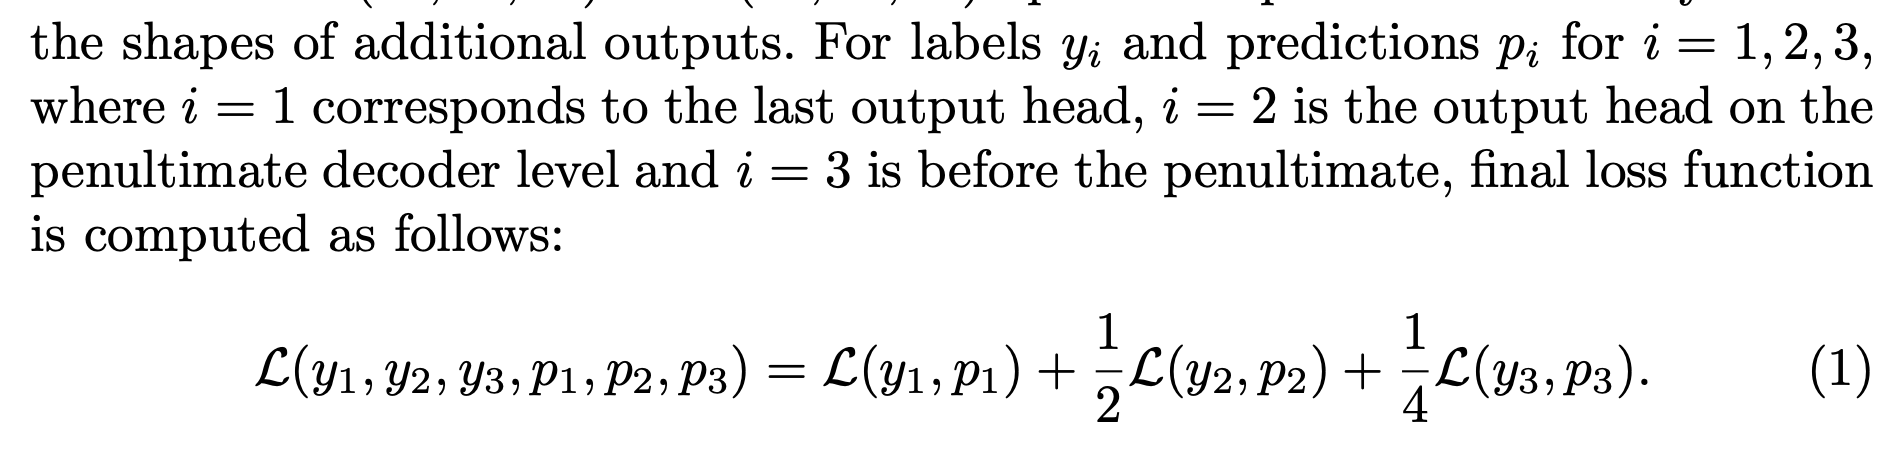